### General EOS Noh problem

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.interpolate

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\entrainment\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

In [26]:
# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing
import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT
import physics.multiphaseWLMA.multiphaseWLMA as multiphaseWLMA
import physics.multiphaseWLMA.iapws95_light.mixtureWLMA as mixtureWLMA
import physics.multiphasevpT.atomics as atomics

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

from types import SimpleNamespace

os.chdir(target_dir)

#### Axisymmetric Noh for mixture 

In [27]:
# Instantiate physics object
physics = multiphasevpT.MultiphasevpT1D(meshing.meshbase.Mesh())
# Set default physical parameters
physics.set_physical_params()

In [28]:
# Set mass fraction (air, water vapor, magma)
yM = 0.999
yVec = np.array([1-yM, 0.0*yM, yM])[np.newaxis, np.newaxis, :]
# Set reference state
p_inf   = 1e-5
# Pick T_inf such that rho_inf == 1
T_inf_guess   = 2.5e-3*p_inf
def rho_pT(p, T):
  v_inf = atomics.mixture_spec_vol(yVec, p, T, physics)
  rho_inf = float(1.0 / v_inf)
  return rho_inf
# Solve for T_inf
T_inf_soln = scipy.optimize.root_scalar(lambda T: rho_pT(p_inf, T) - 1.0,
  x0=T_inf_guess,
  x1=2*T_inf_guess,
  xtol=1e-16, rtol=1e-8)
if not T_inf_soln.converged:
  raise ValueError(f"T_inf did not converge: dumping soln object: {T_inf_soln}")
T_inf = T_inf_soln.root
rho_inf = rho_pT(p_inf, T_inf)
v_inf = 1.0 / rho_inf
# Compute mass-fraction-dependent quantities
Gamma = atomics.Gamma(yVec, physics)
# Define kappa index
kappa = (Gamma - 1) / Gamma
# Check gas volume fraction of inf state
phi_inf = atomics.gas_volfrac(rho_inf * yVec, T_inf, physics)
phi_inf, rho_inf, T_inf

(array([[[0.999629814907454]]]), 0.9999999999999998, 3.483030713963251e-05)

In [29]:
''' Tools for computing pressure along isentrope.
Isentropic relation + equation of state leaves one degree of freedom for
thermodynamic state (mixture density). '''

def bulk_modulus(rho, p, T):
  ''' Isentropic bulk modulus '''
  arhoVec = yVec * rho
  Gamma = atomics.Gamma(arhoVec, physics)
  phi = atomics.gas_volfrac(arhoVec, T, physics)
  c   = atomics.sound_speed(Gamma, p, rho, phi, physics)
  return rho * c * c

def volume_residual(p, rho, p_inf, T_inf) -> float:
  T = T_inf * (p / p_inf) ** kappa
  v = atomics.mixture_spec_vol(yVec, p, T, physics)
  return float(v - 1 / rho)

def p_along_isentrope(rho_target, p_inf, T_inf):
  soln = scipy.optimize.root_scalar(
    lambda p: volume_residual(p, rho_target, p_inf, T_inf),
      x0=p_inf, x1=p_inf*1.1,
      rtol=1e-8)
  if not soln.converged:
    raise ValueError(f"Root-finding failed. Dumping soln object: {soln}")
  return soln.root

Inverted p_s(rho), K_s(rho) relations: 
Recall bulk modulus of ideal gas: gamma * p


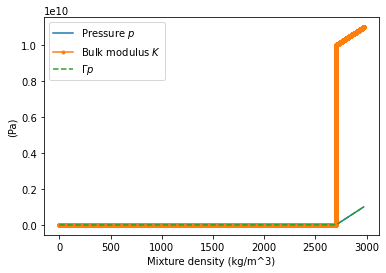

In [30]:
# Test atomics
arhoVec = yVec * rho_inf
phi = atomics.gas_volfrac(arhoVec, T_inf, physics)
c   = atomics.sound_speed(Gamma, p_inf, rho_inf, phi, physics)
K = bulk_modulus(rho_inf, p_inf, T_inf)

# Show residual for one target density
test_one_case = False
if test_one_case:
  rho_target = 10.0
  p_range = np.geomspace(1, 1e7, 200)
  vol_res = [(volume_residual(p, rho_target, p_inf, T_inf)**2) for p in p_range]
  plt.loglog(p_range, vol_res, '.-')
  # Set new figure for future plotting
  plt.figure()

# Compute interpolation range
p_isentrope = np.geomspace(1e-9, 1e9, 1000000)[:, np.newaxis, np.newaxis]
T_isentrope = T_inf * (p_isentrope / p_inf) ** kappa
rho_isentrope = 1.0 / atomics.mixture_spec_vol(
  yVec,
  p_isentrope,
  T_isentrope,
  physics)
K_isentrope = bulk_modulus(rho_isentrope, p_isentrope, T_isentrope)

# plt.figure(figsize=(12,6))
# plt.subplot(1,2,1)
plt.plot(rho_isentrope.ravel(), p_isentrope.ravel(), '-')
plt.xlabel("Mixture density (kg/m^3)")
# plt.ylabel("Pressure (Pa)")
# plt.subplot(1,2,2)
plt.plot(rho_isentrope.ravel(), K_isentrope.ravel(), '.-')
plt.plot(rho_isentrope.ravel(), (Gamma * p_isentrope).ravel(), '--')

# plt.xlabel("Mixture density (kg/m^3)")
# plt.ylabel("Bulk modulus (Pa)")
plt.ylabel("(Pa)")
plt.legend(["Pressure $p$", "Bulk modulus $K$", "$\Gamma p$"])

print("Inverted p_s(rho), K_s(rho) relations: ")
print("Recall bulk modulus of ideal gas: gamma * p")

In [31]:
''' Bind interpolants '''
K_rho:callable = scipy.interpolate.CubicSpline(rho_isentrope.ravel(), K_isentrope.ravel())
p_rho:callable = scipy.interpolate.CubicSpline(rho_isentrope.ravel(), p_isentrope.ravel())

In [32]:
K_rho(rho_inf) / rho_inf

1.0004660971432365e-05

Testing one ODE solve...
Last xU: -1.0000000000560068
u_inf:   300.000000016802


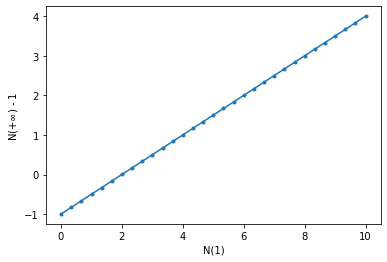

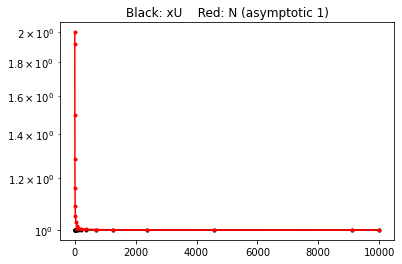

In [33]:
def RHS(x, q, us):
  ''' ODE RHS with 
    q = [U, N],
  and Aq' = b(q) from
    (U-1) (U+xU') + K/(rho_inf*us**2) * N' / (N*N) == 0 # Momentum
    (U-1) x N' / N + 2U + xU' == 0.                     # Mass
  Here x is the similarity variable.
  '''
  U, N = q
  
  # Ideal gas bulk modulus
  rho = N * rho_inf
  K = float(K_rho(rho))
  # Compute inv(A) @ b
  A = np.array([[(U-1)*x, K/(rho_inf*us**2) / (N*N)], [x, (U-1) * x / N]])
  b = np.array([(1-U)*U,-2*U])
  _detA = A[1,1] * A[0,0] - A[1,0] * A[0, 1]
  x = np.zeros_like(b)
  x[0] = (A[1,1] * b[0] - A[0,1] * b[1]) / _detA
  x[1] = (-A[1,0] * b[0] + A[0,0] * b[1]) / _detA
  return x

def solve_outer(q0, us):
  ''' Return solution object for outer solution '''
  return scipy.integrate.solve_ivp(lambda x, q: RHS(x, q, us), [1, 10_000], q0)

# Solve infinity boundary condition residual
def inf_residual(U, N, us):
  ''' Solve outer problem and return infinity BC residual (N - 1)'''
  out = solve_outer(np.array([U, N]), us)
  return out.y[1,-1] - 1

''' Compute N(x=1) that satisfies infinity boundary condition '''
def match_infty_N_BC(U0, us):
  rootf_soln = scipy.optimize.root_scalar(lambda N: inf_residual(U0, N, us),
                                          bracket=[1e-5, 1e5], method='brenth')
  if not rootf_soln.converged:
    raise ValueError(f"Could not converge root-finding for N(1). Dumping "
                     + f"returned solution from root_scalar.\n{rootf_soln}")
  return rootf_soln

# Try test values
U0 = -1.0
us = 300
# Generate test plot for residual as a function of N (want root of residual)
_test_N_vector = np.linspace(0.01, 10, 31)
_test_residual_vector = [inf_residual(U0, N, us) for N in _test_N_vector]
plt.plot(_test_N_vector, _test_residual_vector, '.-')
plt.ylabel("N($+\infty$) - 1")
plt.xlabel("N(1)")

''' Compute outer solution. '''
rootf_soln = match_infty_N_BC(U0, us)
N0 = rootf_soln.root
q0 = np.array([U0, N0])
# Solve outer solution
out = solve_outer(q0, us)
# Extract u_inf from asymptotic value
u_inf = -us * (out.t[-1] * out.y[0,-1])

# Plot outer solution with initial guess for interface (U, N)
plt.figure()
plt.semilogy(out.t, -out.t * out.y[0,:], 'k.-')
plt.plot(out.t, out.y[1,:], 'r.-')
plt.plot(out.t, np.ones_like(out.t), 'r--')
plt.title("Black: xU    Red: N (asymptotic 1)")
print("Testing one ODE solve...")
print(f"Last xU: {out.t[-1] * out.y[0,-1]}")
print(f"u_inf:   {u_inf}")

In [34]:
def compute_shock_velocity_mixture(q, us, full_output:bool=False):
  ''' Using q == (U, N), compute the shock velocity satisfiying RH.
  Mass is used to compute density.
  Hugoniot (mixed mass-momentum-energy) is used to compute pressure.
  Momentum is used to compute shock velocity. '''

  Uplus, Nplus = q
  # Compute dimensional quantities on either side of the shock
  Nminus = Nplus * (1 - Uplus)
  rhominus = rho_inf * Nminus
  rhoplus  = rho_inf * Nplus
  vminus = 1.0 / rhominus
  vplus = 1.0 / rhoplus
  uminus = 0
  uplus = Uplus * us
  pplus = p_rho(rhoplus)
  # Unpack material properties (external)
  yM = float(yVec[...,2])
  K = physics.Liquid["K"]
  rhom0 = physics.Liquid["rho0"]
  pm0 = physics.Liquid["p0"]
  # Compute gas volume fraction
  phiplus = 1 - yM * rhoplus / (rhom0 * (1 + (pplus - pm0) / K))

  # Compute post-shock pressure from Hugoniot:
  _a = 0.5 * (Gamma-1) * (vminus - vplus) +  vminus
  _b = yM * K / rhom0
  _c = K - pm0 
  _d = -0.5 * (Gamma-1) * (vminus - vplus) * pplus + phiplus * pplus * vplus
  # Quadratic formula
  _A = _a
  _B = _a * _c - _b - _d
  _C = -_c * _d
  rootminus = 0.5 / _A * (-_B - np.sqrt(_B*_B - 4*_A*_C))
  rootplus = 0.5 / _A * (-_B + np.sqrt(_B*_B - 4*_A*_C))
  pminus = float(rootplus)
  # Output shock velocity from momentum condition
  us_out = (pplus - pminus) / (rhominus * uplus)
  if full_output:
    return us_out, {
      "pminus": pminus,
      "pplus": pplus,
      "rhominus": rhominus,
      "rhoplus": rhoplus,
      "rootminus": rootminus,
      "rootplus": rootplus,
    }
  return float(us_out)

In [35]:
''' Check output of one RH-solve '''
print(compute_shock_velocity_mixture(q0, 100, full_output=True))
print("Note that rootminus is unphysical.")

(5.0118756953319715e-08, {'pminus': 4.005223354913028e-05, 'pplus': array(2.000673531706655e-05), 'rhominus': 3.999600040107534, 'rhoplus': 1.999800020053767, 'rootminus': array([[[-9.980200771416166e+09]]]), 'rootplus': array([[[4.005223354913028e-05]]])})
Note that rootminus is unphysical.


In [50]:
''' Check feasible values of U '''
-2/(Gamma-1)

array([[[-20890.017421616983]]])

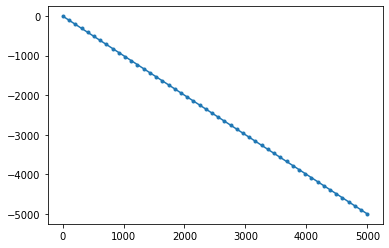

In [60]:
''' Map Hugoniot residual for fixed U0 '''
U0 = -50 # -50 # -2/(float(Gamma)-1) + 8e-2
# U0 = -4 + 1e-2 #ideal gas
# For dilute mixture:
# U0 = -2/(float(Gamma)-1) + 1e-5 # -13. # -2/(Gamma-1)

# Hugoniot residual
def compute_hugoniot_residual(U0, us):
  rootf_soln = match_infty_N_BC(U0, us)
  N0 = rootf_soln.root
  us_hugoniot = compute_shock_velocity_mixture(np.array([U0, N0]), us)
  return us_hugoniot - us

test_us_vector = np.linspace(5, 5000 ,50) # np.linspace(100, 500 ,50)
test_hres_vector = [compute_hugoniot_residual(U0, us) for us in test_us_vector]
plt.plot(test_us_vector, test_hres_vector, '.-')

In [61]:
''' Use visual curve for initial guess to iterative solver for Hugoniot residual. '''
us_soln = scipy.optimize.root_scalar(lambda us: compute_hugoniot_residual(U0, us),
                                     x0=1e-5, x1=.2, method='secant')
us_soln

      converged: True
           flag: 'converged'
 function_calls: 5
     iterations: 4
           root: 0.018219062427731445

U, N compared to asymptotic (K = 0) strong shock pseudogas solution


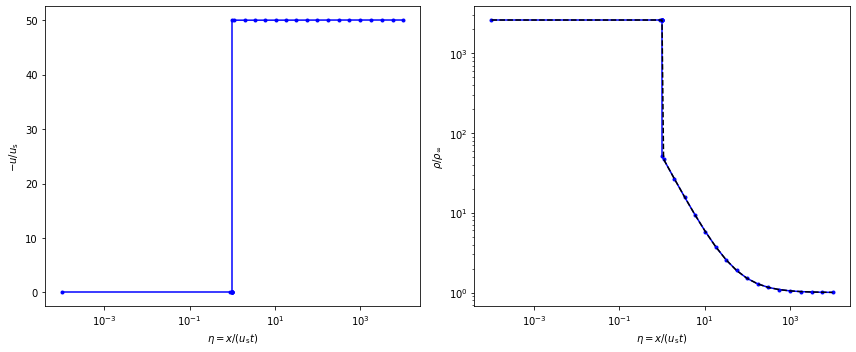

In [62]:
''' Solve interior solution '''

# Use fixed U0, solved shock velocty us to compute N0
rootf_soln = match_infty_N_BC(U0, us_soln.root)
N0 = rootf_soln.root
out = solve_outer(np.array([U0, N0]), us_soln.root)
# Compute (Uminus, Nminus,) from mass RH
Uminus = 0
Nminus = rootf_soln.root * (1 - U0)
qminus = np.array([Uminus, Nminus])
# Solve interior solution numerically
soln_interior = scipy.integrate.solve_ivp(lambda x, q: RHS(x, q, us_soln.root), [1, 1e-4], qminus)
is_show_asymptotic:bool = True

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
# Exterior solution for -u/u_s
plt.semilogx(out.t, -out.t * out.y[0,:], 'b.-')
# Interior solution for -u/u_s
plt.plot(soln_interior.t, -soln_interior.t * soln_interior.y[0,:], 'b.-')
# Plot vertical jump
plt.plot([1, 1], [-soln_interior.y[0,0], -out.y[0,0]], 'b-')

# Plot infinite strength shock limit solution
asymptotic_t = np.unique([*soln_interior.t, *out.t])
asymptotic_u = np.where(asymptotic_t <= 1, 
                        np.zeros_like(asymptotic_t),
                        2/(float(Gamma)-1))
# Exterior asymptote
if is_show_asymptotic:
  ''' '''
  # plt.plot(asymptotic_t, asymptotic_u, 'k--')
# Add labels
plt.xlabel("$\eta = x/(u_\mathrm{s} t)$")
plt.ylabel("$-u/u_\mathrm{s}$")

plt.subplot(1,2,2)
# Exterior solution for rho/rho_infty
plt.loglog(out.t, (1 - U0/out.t), 'b.-')
# Interior solution
plt.plot(soln_interior.t, soln_interior.y[1,:], 'b.-')
# Plot vertical jump
plt.plot([1, 1], [soln_interior.y[1,0], (1 - U0)], 'b-')

# Infinite strength shock limit solution
asymptotic_t = np.unique([*soln_interior.t, *out.t])
asymptotic_rho = np.where(asymptotic_t <= 1, 
                          (1 - U0) ** 2,
                          1 - U0/asymptotic_t)
# Exterior asymptote
if is_show_asymptotic:
  plt.plot(asymptotic_t, asymptotic_rho, 'k--')
# Add labels
plt.xlabel("$\eta = x/(u_\mathrm{s} t)$")
plt.ylabel(r"$\rho/\rho_{\infty}$")
plt.tight_layout()
print("U, N compared to asymptotic (K = 0) strong shock pseudogas solution")

In [63]:
''' Report compression ratios '''
# Extract pressure ratio
_, shocked_dict = compute_shock_velocity_mixture(
  np.array([U0, rootf_soln.root]), us_soln.root, full_output=True)
pminus = shocked_dict["pminus"]
pplus = shocked_dict["pplus"]

Nratio = Nminus / rootf_soln.root
print(f"Density compression ratio: {Nratio:e}")
print(f"Pressure jump (difference), numerical ODE: {pminus - pplus:e}")
print(f"Pressure ratio, numerical ODE: {pminus / pplus:e}")

Density compression ratio: 5.100000e+01
Pressure jump (difference), numerical ODE: 6.636096e-01
Pressure ratio, numerical ODE: 1.283373e+03


In [59]:
# Extract initial condition needed for numerical simulation
N0 * rho_inf
print(f"U0 (prescribed): {U0}")
u_inf = out.y[0,-1] * out.t[-1] * us_soln.root
print(f"U(x=+infty): {out.y[0,-1] * out.t[-1]}")
print(f"IC u based on U0: {U0 * us_soln.root}")
print(f"IC u based on U(x=+infty)): {u_inf}")
print(f"IC rho_inf: {rho_inf}")
print(f"BC rho: rho_inf * (1 + {-u_inf} * t / x_BC)")
print(f"IC T_inf: {T_inf}")


U0 (prescribed): -40
U(x=+infty): -40.927195295109044
IC u based on U0: -0.13025005271804901
IC u based on U(x=+infty)): -0.13326923361974602
IC rho_inf: 0.9999999999999998
BC rho: rho_inf * (1 + 0.13326923361974602 * t / x_BC)
IC T_inf: 3.483030713963251e-05


In [42]:
us_soln.root, 1.0 / us_soln.root

(0.018219062427731445, 54.8875664687272)

In [65]:
phi_inf

array([[[0.999629814907454]]])

In [44]:
1 / 0.0018109131481262987

552.2075981582398

In [64]:
1/(1 - 1/Gamma)

array([[[10446.00871081381]]])